In [1]:
%%time
!pip install -q --upgrade pip fastai

CPU times: user 23.4 ms, sys: 6.62 ms, total: 30 ms
Wall time: 1.73 s


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks import CSVLogger

In [4]:
NUMBER_OF_SAMPLES = 50_000
SIZE = 224 // 8 
MAGNIFICATION = 8
INSETS = 2
THRESHOLD = 0.8

NUMBER_OF_SAMPLES * SIZE * SIZE

39200000

# Creating test data

In [5]:
from PIL import ImageDraw as PILImageDraw
from PIL import Image as PILImage

def create_data():
    return np.random.standard_normal(
        size=(NUMBER_OF_SAMPLES, SIZE, SIZE)) > THRESHOLD

def get_label(data):
    return float(np.sum(data, axis=(0,1)))

def render_image(data):
    img = PILImage.new('RGB', (SIZE*MAGNIFICATION, SIZE*MAGNIFICATION), color = (255,255, 255))
    draw = PILImageDraw.Draw(img)

    for (row_index, row) in enumerate(data):
        for (col_index, value) in enumerate(row):
            x0, y0 = row_index*MAGNIFICATION+INSETS, col_index*MAGNIFICATION+INSETS
            x1, y1 = ((row_index+1)*MAGNIFICATION-INSETS)+1, \
                     ((col_index+1)*MAGNIFICATION-INSETS)+1

            if value: 
                draw.rectangle([(x0, y0), (x1, y1)], fill=(255, 153, 0))  
                
    return Image(pil2tensor(img, np.float32).div(255))

class MyImageItemList(ImageList):
    def __init__(self, path, items, **kwargs):
        super().__init__(items, **kwargs)
        self.path = path
    
    def get(self, i):
        return render_image(self.items[i])

In [6]:
%%time
np.random.seed(42)
dt = create_data()
iil = MyImageItemList(Path('.'), items=dt)
ll = iil.split_by_rand_pct(0.2)
ll.label_from_func(get_label)

CPU times: user 2.25 s, sys: 143 ms, total: 2.39 s
Wall time: 2.39 s


# Create CNN

In [7]:
def plot_results(learner, label=None):
    model.recorder.plot_losses()
    plt.yscale('log')
    if label: plt.title(label)

    model.recorder.plot_losses()
    plt.yscale('log')
    plt.ylim(0,10)
    if label: plt.title(label)

    model.recorder.plot_losses()
    plt.ylim(0,3)
    if label: plt.title(label)

In [8]:
data_bunch = ll.databunch(bs=70)
data_bunch = data_bunch.normalize(imagenet_stats)
model = cnn_learner(data_bunch, models.resnet152, ps=0, true_wd = False, bn_wd = False)
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


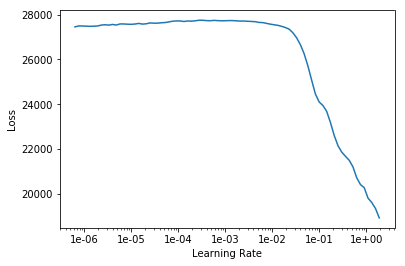

In [9]:
model.recorder.plot()

In [10]:
lr = 5e-1; lr

0.5

In [11]:
model.fit_one_cycle(50, lr, wd=0)

epoch,train_loss,valid_loss,time
0,12.050157,71.950935,03:54
1,11.967238,11969.459961,03:52
2,9.565013,156918.828125,03:52
3,23.452873,474162.593750,03:52
4,23.936331,1166262.125000,03:52
5,28.175610,134895.750000,03:51
6,21.582893,297.018372,03:51
7,33.180927,8852414464.000000,03:51
8,19.070518,69167696.000000,03:51
9,10.283192,21588314112.000000,03:51


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


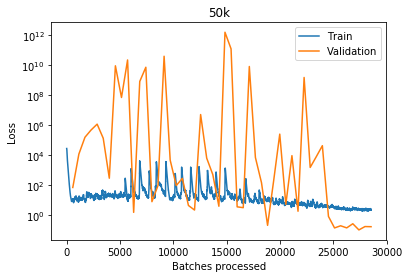

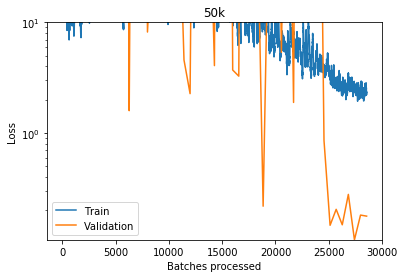

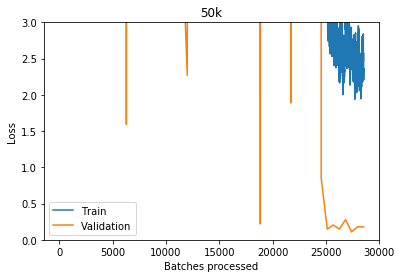

In [12]:
plot_results(model, '50k')

In [13]:
model.save('50k1')

In [14]:
model.load('50k1')

Learner(data=ImageDataBunch;

Train: LabelList (40000 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
153.0,186.0,162.0,162.0,155.0
Path: .;

Valid: LabelList (10000 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
164.0,176.0,184.0,171.0,164.0
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2)

In [15]:
model.fit_one_cycle(25, lr, wd=0)

epoch,train_loss,valid_loss,time
0,2.387086,0.937002,03:52
1,5.751566,17.020250,03:51
2,7.523307,676.276245,03:52
3,19.261518,170.493500,03:52
4,16.479464,26.074179,03:52
5,13.314901,84045.742188,03:52
6,17.442444,1967262.750000,03:52
7,367.855682,19671949312.000000,03:52
8,11.233271,5.886855,03:52
9,21.057587,23709980.000000,03:53


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


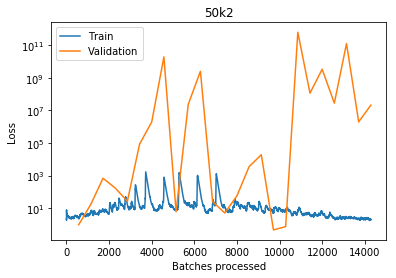

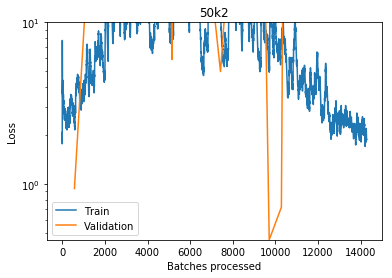

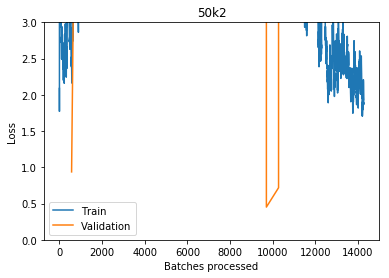

In [16]:
plot_results(model, '50k2')

In [17]:
model.save('50k2')

In [18]:
model.load('50k2')

Learner(data=ImageDataBunch;

Train: LabelList (40000 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
153.0,186.0,162.0,162.0,155.0
Path: .;

Valid: LabelList (10000 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
164.0,176.0,184.0,171.0,164.0
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2)

In [19]:
NUMBER_OF_SAMPLES = 250

In [20]:
%%time
np.random.seed(42)
dt = create_data()
iil = MyImageItemList(Path('.'), items=dt)
ll = iil.split_by_rand_pct(0.2)
ll.label_from_func(get_label)

CPU times: user 6.8 ms, sys: 7.83 ms, total: 14.6 ms
Wall time: 14.3 ms


In [21]:
#model.fit_one_cycle(3, slice(lr), wd=0)

In [22]:
data_bunch = ll.databunch(bs=70)
data_bunch = data_bunch.normalize(imagenet_stats)
model = cnn_learner(data_bunch, models.resnet152, ps=0, true_wd = False, bn_wd = False)
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


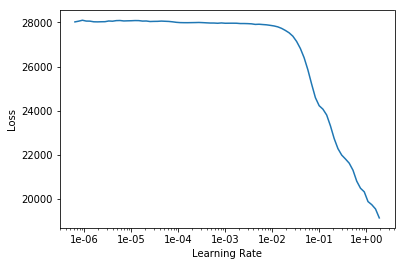

In [23]:
model.recorder.plot()

In [24]:
lr = 1e-2; lr # 6e-2 already doesn't work anymore

0.01

In [ ]:
model.fit_one_cycle(10000, lr, wd=0) # 50_000 / 250 = 200 -> 200 * 50 epochs 

epoch,train_loss,valid_loss,time
0,27987.667969,27718.410156,00:03
1,27808.367188,27739.705078,00:02
2,27823.109375,27714.490234,00:02
3,27881.138672,27789.625000,00:02
4,27934.904297,27917.082031,00:02
5,27932.224609,27951.455078,00:02
6,27943.644531,27891.970703,00:02
7,27933.146484,27884.394531,00:02
8,27920.472656,27943.984375,00:02
9,27891.326172,28074.730469,00:02


In [ ]:
plot_results(model, 'small')

In [ ]:
model.save('small')

In [ ]:
_ = model.load('small')